# Static Stack Usage Survey

Here are the results of my static analysis of popular open source applications' stack memory usage. This notebook is designed to process CSV files generated by [EscapeAnalysisTool](https://github.com/bencole12345/EscapeAnalysisTool).

## Overview

The goal of this survey is to analyse popular applications' usage of stack memory, with a particular focus on the usage of escaping stack allocations. Following is a brief explanation of what escaping values are, and how the tool detects them. Later I use EscapeAnalysisTool to analyse the source code of popular open source applications, with a view to determining which factors should be considered when designing techniques to provide temporal stack memory safety in C and C++ code.

### Escaping Variables

An *escaping* value is a value for which a reference to that value (i.e. a pointer) may "escape" the scope in which the function is defined. Consider the following code:
```c++
void callee(int **p) {
    int x = 12;
    *p = &x;
}

void caller() {
    int *p;
    callee(&p);
    // *p == ??
}
```
In the function `callee`, the value `12` is considered to be escaping because a pointer to it is assigned to a name accessible from `caller`'s scope. That is, a reference to the variable *escapes* the lexical scope in which the variable was defined. This is legal C++, so long as the pointer `p` is never dereferenced once `x` is out of scope.

A possible use-case for this paradigm might be to set attributes on a struct that was passed in by pointer from the callee for calling a later function. For example:
```c++
struct StructFromCaller {
    UsefulInformation *usefulInformation;
    ...
}

void example(StructFromCaller *fromCaller) {
    // Create a local object to hold the result of the function call
    UsefulInformation useful;
    
    // Write it to the object passed in by the caller
    // (this line is where the pointer "escapes")
    fromCaller->usefulInformation = &useful;
    
    // Pass on this object to a function that writes some output
    // to the usefulInformation pointer
    functionThatWritesUsefulInformation(objectFromParent);
    
    // Use the result that was generated
    if (useful.blah) {
        ...
    }
}
```

If the pointer `fromCaller->usefulInformation` is never dereferenced by the caller after the function has terminated, then this is still valid C++ code.

### Escape Analysis

LLVM includes an *escape analysis* pass that can predict whether a particular value may escape a function. One potential application is to enable the optimiser to move non-escaping heap-allocated values to the stack, which is cheaper. Unfortunately, like many interesting program analyses, escape analysis is undecideable in general, so LLVM is forced to offer a safe overapproximation of which values may escape. Later on in the report I will consider the rate and nature of false positives.

The reason we are interested in escape analysis is that escaping values are also a *possible* source of vulnerabilities in C and C++ code. The previous examples are only valid so long as the escaping pointers are not dereferenced after the values have fallen out of scope. Doing so leads the program into undefined behaviour because of a **temporal stack memory violation**.

This is dangerous because such violations may not be obvious to a human programmer - especially if they are unaware that a pointer no longer points to valid memory. Attempts to do so will likely corrupt memory and cause undesired execution behaviour. A motivated attacker may be able to exploit this to overwrite function return addresses and gain arbitrary code execution, or alternatively might be able to obtain access to priviliged information.

## The Analysis

So far I analyse the stack usage of three popular open-source applications:

- **Clang**, a C/C++ compiler built using LLVM
- **GNU Grep**, a command-line utility for searching files for lines that match a regular expression
- **ocamlrun**, the interpreter and runtime for the OCaml functional programming language

For compiling the source code to LLVM IR I used [GLLVM](https://github.com/SRI-CSL/gllvm) to emit LLVM bitcode (`.bc`) files. For analysing the generated LLVM IR code I disassembled the `.bc` files to human-readable `.ll` textual format files using the command-line tool `llvm-dis`.

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

# See helpers/graphs.py for the code that plots the histograms and CDFs.
from helpers.graphs import (
    all_allocations_size_histogram,
    escaping_allocations_size_histogram,
    stack_allocation_sizes_histogram_and_cdf,
    stack_allocation_counts_histogram_and_cdf
)

data_dir = Path('notebook_data')

# Note: clang.csv is excluded from the repository because it's >100 MB, too big for GitHub!
clang_data = pd.read_csv((data_dir / 'clang.csv').resolve(), sep=';')
grep_data = pd.read_csv((data_dir / 'grep.csv').resolve(), sep=';')
ocamlrun_data = pd.read_csv((data_dir / 'ocamlrun.csv').resolve(), sep=';')

all_data = [clang_data, grep_data, ocamlrun_data]
labels = ["Clang", "Grep", "ocamlrun"]

## Example Data

Here is an example of some of the data produced by the tool.

In [2]:
clang_data

,FunctionName,NumInstructions,NumAllocaInvocations,NumEscapingAllocaInvocations,NumDynamicallySizedAllocaInvocations,NumDynamicallySizedEscapingAllocaInvocations,TotalStaticallyAllocatedStackMemory,TotalStaticallyAllocatedEscapingStackMemory
0,clang::ConstructionContextItem::getKindAsStrin...,28,2,1,0,0,20,16
1,clang::ConstructionContextItem::getKindAsStrin...,16,2,0,0,0,24,0
2,clang::ConstructionContextItem::getKind() const,6,1,0,0,0,8,0
3,llvm::StringRef::StringRef(char const*),19,2,0,0,0,16,0
4,llvm::StringRef::strLen(char const*),5,1,0,0,0,8,0
...,...,...,...,...,...,...,...,...
877320,llvm::itanium_demangle::FunctionEncoding::getC...,6,1,0,0,0,8,0
877321,llvm::itanium_demangle::FunctionEncoding::getR...,6,1,0,0,0,8,0
877322,llvm::ItaniumPartialDemangler::isCtorOrDtor() ...,61,3,0,0,0,17,0
877323,llvm::ItaniumPartialDemangler::isSpecialName()...,30,2,0,0,0,9,0


# Overview of the Data

We begin with an overview of the findings across all programs. Later we will analyse each program individually in more detail.

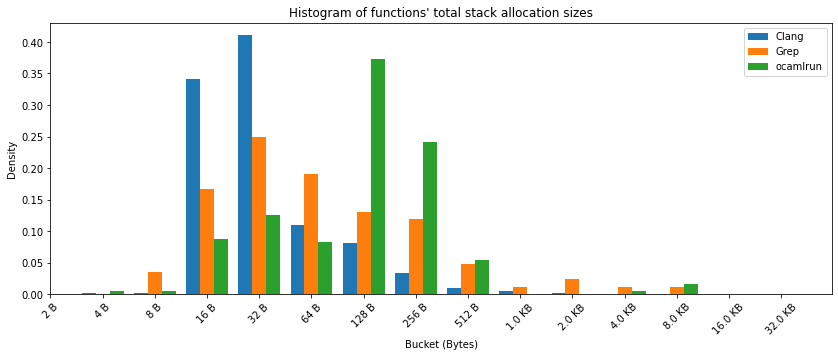

In [3]:
all_allocations_size_histogram(all_data, labels, xlim=(1, 32000))

The plot shows a histogram of allocation sizes across all functions included in the code. Functions are assigned to the next bucket: for example, a 6 KB allocation would fall into the 8 KB bucket.

Clearly the sizes of allocations vary hugely. The amounts of allocated memory per function vary by at least four orders of magnitude in all of the programs analysed.

The ocamlrun program has the largest average allocation size. Grep has a slightly higher mean than Clang but both are largely comparable.

Next is a histogram showing just those allocations that are deemed to be *escaping* by LLVM's escape analysis.

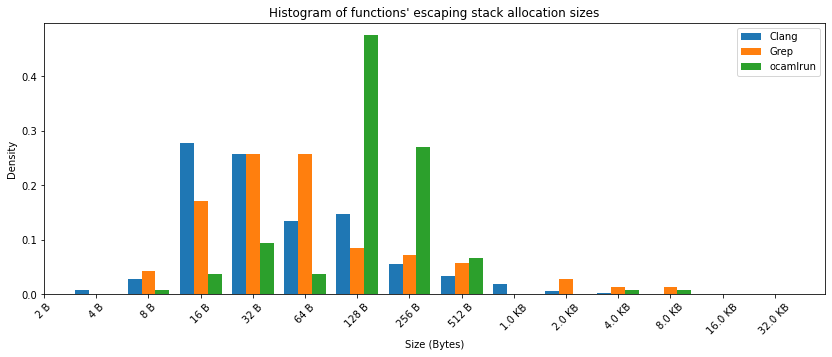

In [4]:
escaping_allocations_size_histogram(all_data, labels, xlim=(1, 32000))

By the fact that the three distributions are all shifted slightly to the right, we can infer that, in all three applications, possibly-escaping allocations are on average slightly larger than an average allocation.

# Deeper Look: Clang

Clang was selected as a popular compiler because compilers are used extensively by programmers, not just for development but also for building software using continuous integration servers. Compilers typically allocate many data structures, from state machines used for parsing to control-flow graphs used by the optimiser. I wanted to see how an allocation-heavy program like Clang uses stack memory and how much of that memory is deemed *escaping* by LLVM's static analysis tool.

## Results from EscapeAnalysisTool

As we can see, the sizes static allocations made by Clang vary by six orders of magnitude, including a very long tail towards the upper end of the histogram. Escaping allocations form a small but certainly non-negligible minority.

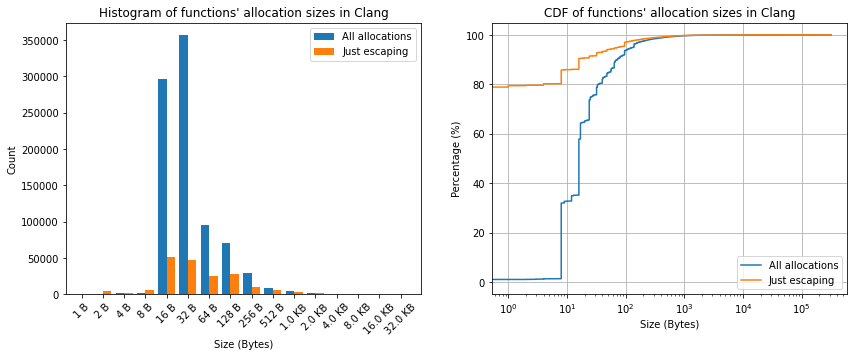

In [5]:
stack_allocation_sizes_histogram_and_cdf(clang_data, "Clang", xlim=(0.3, 32000))

The number of `alloca()` calls also varies, though with a smaller range.

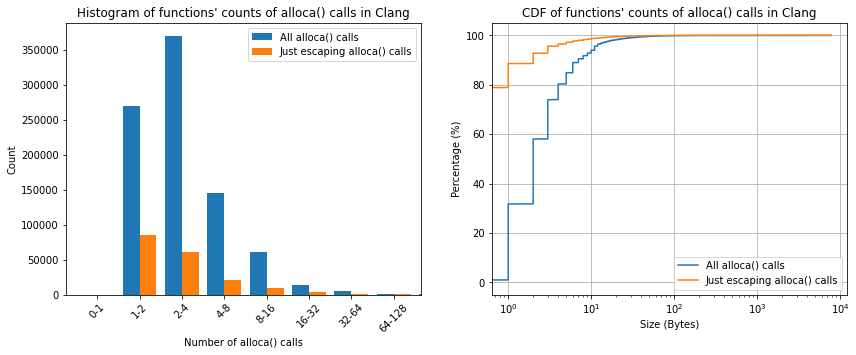

In [6]:
stack_allocation_counts_histogram_and_cdf(clang_data, "Clang", xlim=(0.3, 100))

## Discussion

The primary observation is just how varied the functions are, both in terms of how many static `alloca()` calls they include and how much memory the functions allocate on the stack at compile-time. Clearly, any framework to provide efficient temporal stack memory safety will need to accommodate a wide range of sizes.

### What the biggest allocations are

To get a better feel for what kinds of situations cause a programmer to use a lot of stack memory, I took a deeper look at the five functions with the largest stack frame sizes. The largest functions allocate around 300 KB in total.

An important distinction that will soon become apparent is that the total amount of memory allocated by a function through `alloca()` calls is not necessarily the same as the size of its stack frame at runtime.

In [7]:
clang_data.nlargest(5, "TotalStaticallyAllocatedStackMemory")

,FunctionName,NumInstructions,NumAllocaInvocations,NumEscapingAllocaInvocations,NumDynamicallySizedAllocaInvocations,NumDynamicallySizedEscapingAllocaInvocations,TotalStaticallyAllocatedStackMemory,TotalStaticallyAllocatedEscapingStackMemory
75255,llvm::HexagonEvaluator::evaluate(llvm::Machine...,5339,882,822,0,0,315059,314813
671544,clang::ASTMergeAction::ExecuteAction(),232,28,14,0,0,280708,280608
797648,"llvm::SmallDenseMap<clang::Decl*, llvm::SmallV...",183,12,3,0,0,279380,279304
55296,llvm::ARMAsmPrinter::emitAttributes(),551,36,22,0,0,153816,153720
104105,(anonymous namespace)::RISCVAsmPrinter::emitAt...,80,11,3,0,0,153408,153312


The function with the largest amount of statically-allocated memory, `HexagonEvaluator::evaluate()`, implements an interpreter for the Qualcomm Hexagon architecture, which is designed for DSPs. The definition of the function can be found [here](https://llvm.org/doxygen/structllvm_1_1HexagonEvaluator.html#a49b4d08c8b0024b97c7e090a0b3e50f6). The tool estimated that the function allocates a huge 307 KiB of stack memory, and further that almost all of this is *possibly-escaping*.

The `HexagonEvaluator` class implements `BitTracker::MachineEvaluator` and is used exclusively by the Hexagon backend for determining the data flow path taken by data items in the computation. A typical microarchitectural implementation of the Hexagon architecture benefits from assigning data to *memory cells* in a mapping that minimises data movement between them. The function executes one instruction in a software simulation of the architecture, using a large `switch` statement covering all opcodes in the instruction set. It also records data about the data's movement as well. One of the large stack-allocated structures is a `BitTracker::RegisterCell` object, which encodes a list of register values. Separate instances of these objects are allocated in different control-flow paths.

Two properties of function `HexagonEvaluator::evaluate()` stand out:

- The function includes a large `switch` statement, with one case for each instruction in the instruction set. There are several examples of multiple instructions mapping to the same code block, but all blocks include either a `break` or `return` statement. It is therefore not possible for multiple blocks of the switch statement to be executed in the same invocation of the function.

  This is an example of a situation in which the total amount of memory allocated statically through `alloca()` calls is actually far greater than the true size of the function's stack frame. Since no valid path through the control flow graph includes more than one of the case statement's branches, a compiler would be free to map the local variables of the separate branches to overlapping stack addresses.

- The function defines six C++ lambda functions as local variables, including captures of local variables. This likely contributes significantly to the function's stack frame size, since for each lambda the compiler has to instantiate a struct-like object on the stack.

The list also includes two "pretty printing" functions: `ARMAsmPrinter::emitAttributes()` and `RISCVAsmPrinter::emitAttributes()`. These functions are used for emitting human-readable versions of the assembly code generated by the ARM and RISC-V backends respectively.

The function `ASTMergeAction::ExecuteAction()` consumes lots of stack memory because it allocates several large data structures on the stack. These include an `ASTImporter` object, which contains over 20 attributes.

### What the biggest escaping allocations are

In [8]:
clang_data.nlargest(5, "TotalStaticallyAllocatedEscapingStackMemory")

,FunctionName,NumInstructions,NumAllocaInvocations,NumEscapingAllocaInvocations,NumDynamicallySizedAllocaInvocations,NumDynamicallySizedEscapingAllocaInvocations,TotalStaticallyAllocatedStackMemory,TotalStaticallyAllocatedEscapingStackMemory
75255,llvm::HexagonEvaluator::evaluate(llvm::Machine...,5339,882,822,0,0,315059,314813
671544,clang::ASTMergeAction::ExecuteAction(),232,28,14,0,0,280708,280608
797648,"llvm::SmallDenseMap<clang::Decl*, llvm::SmallV...",183,12,3,0,0,279380,279304
55296,llvm::ARMAsmPrinter::emitAttributes(),551,36,22,0,0,153816,153720
104105,(anonymous namespace)::RISCVAsmPrinter::emitAt...,80,11,3,0,0,153408,153312


The functions with the most stack-allocated escaping memory appear to be exactly the same as those with the largest stack allocations overall, showing that the functions that make large allocations tend also to be *escaping*.

### Key findings

- The performance of a temporal safety scheme depends on its per-`alloca()` runtime overheads, but this is not the full story. The existence of highly-branching functions like `HexagonEvaluator::evaluate()` shows that we equally need to look out for overheads that would exist per static allocation, regardless of whether the path is taken. This function contains many possible control-flow paths, each containing allocations, but only one will ever actually be taken at a time.

  Such constructions are particularly common in the source code of compilers, where functions need to perform a switch statement over all possible types of some tree-like data structure.

# Deeper Look: GNU Grep

Grep is a Unix tool for searching text files for lines that match a regular expression. It was selected because, like many tools, the program is typically executed for a single task before the process terminates. I wanted to determine the extent to which this influences programming styles.

## Results from EscapeAnalysisTool

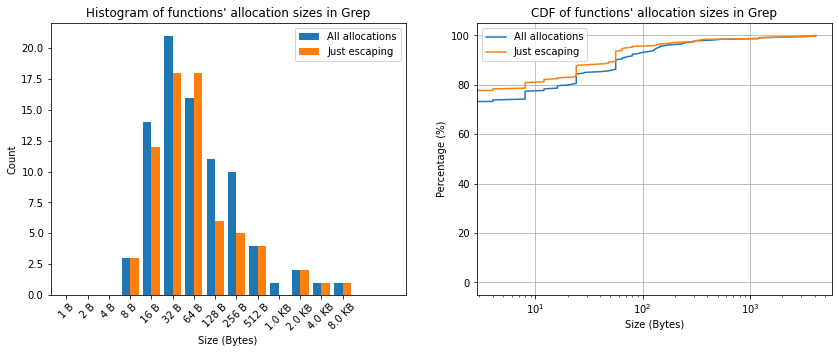

In [9]:
stack_allocation_sizes_histogram_and_cdf(grep_data, "Grep", xlim=(0.3, 32000))

*Note: There aren't actually any functions reported as having more escaping stack-allocated values than stack-allocated values in general. The reason for the appearance of this in the graph is that the combined value of escaping + non-escaping allocations sometimes crosses a threshold and counts for a bigger bucket instead.*

In [10]:
np.any(grep_data["TotalStaticallyAllocatedEscapingStackMemory"] > grep_data["TotalStaticallyAllocatedStackMemory"])

False

The most immediately obvious difference between the data for Grep and that for Clang is that a much larger proportion of Grep's `alloca()` calls are deemed escaping by LLVM's escape analysis.

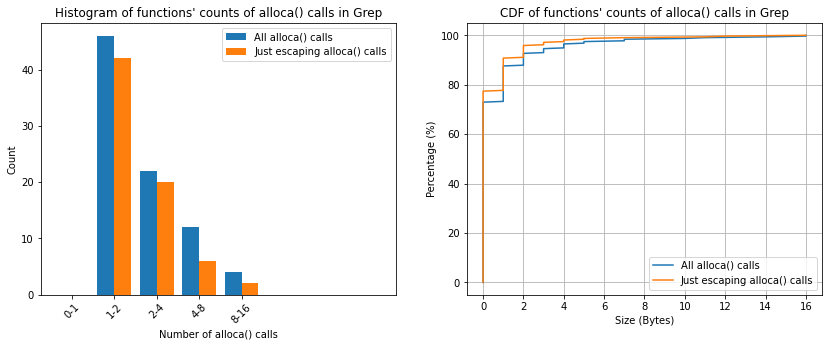

In [11]:
stack_allocation_counts_histogram_and_cdf(grep_data, "Grep", xlim=(0.3, 100), log_cdf=False)

### Discussion

Compared with Clang, Grep's stack allocations are on average slightly smaller. In particular, the largest allocations in Clang are almost an order of magnitude larger. This makes sense: Grep is a C program, relying extensively on dynamically-allocated structures, whereas Clang is written in C++ using lots of modern C++ techniques like RAII (resource acquisition is initialisation), which encourages lots of stack usage.

### Largest allocations and escaping allocations

Let's take a look at the largest five functions to see what's causing such big allocations, and to determine whether the allocations really are *escaping*.

In [12]:
grep_data.nlargest(5, "TotalStaticallyAllocatedStackMemory")

,FunctionName,NumInstructions,NumAllocaInvocations,NumEscapingAllocaInvocations,NumDynamicallySizedAllocaInvocations,NumDynamicallySizedEscapingAllocaInvocations,TotalStaticallyAllocatedStackMemory,TotalStaticallyAllocatedEscapingStackMemory
61,die,42,1,1,0,0,4098,4098
33,kwsprep,507,3,3,0,0,2312,2312
49,Pcompile,150,3,3,0,0,1212,1212
50,Pexecute,153,1,1,0,0,1200,1200
9,main,1144,16,12,0,0,532,380


In [13]:
grep_data.nlargest(5, "TotalStaticallyAllocatedEscapingStackMemory")

,FunctionName,NumInstructions,NumAllocaInvocations,NumEscapingAllocaInvocations,NumDynamicallySizedAllocaInvocations,NumDynamicallySizedEscapingAllocaInvocations,TotalStaticallyAllocatedStackMemory,TotalStaticallyAllocatedEscapingStackMemory
61,die,42,1,1,0,0,4098,4098
33,kwsprep,507,3,3,0,0,2312,2312
49,Pcompile,150,3,3,0,0,1212,1212
50,Pexecute,153,1,1,0,0,1200,1200
9,main,1144,16,12,0,0,532,380


Interestingly, the five functions with the largest escaping stack allocations are also the five largest functions overall. For all except `main()`, all of their allocations were deemed to be escaping.

- The function `die()` is called to terminate the program. For obvious reasons, this does not need to worry too much about careful memory management: the process is about to be deleted. The large allocation is used to hold a human-readable error message string.

- The function `kswprep()` "prepares a built keyword set for use", meaning that it converts a set of keywords the parser is looking for into a data structure that forms an automaton for processing the input. It contains only three `alloca()` calls, but all of them are deemed to be escaping.

  Two of these are interesting: they are stack-allocated arrays of constant length 256, each containing an element for each possible `char` that could be encountered by a parser. One is named `deltabuf` and contains `unsigned char`s: the other is called `nextbuf` and contains `struct trie *` elements. Both of these are internal data structures used by the Aho-Corasick algorithm that the programmer decided to stack-allocate since they are of a size known in advance.
  
  Unfortunately, these are a large number of **false positives** that don't actually escape at all. The problem is that LLVM's escape analysis appears to be intra-procedural only, so when it observes a pointer to a local variable being passed to another function in a function call, it has to choose the safe option of reporting the pointer as possibly-escaping, even if the function being called is definitely not escaping. For example, a pointer to the `deltabuf` array is passed to a function `treedelta()` that applies an update procedure to elements of a tree structure used by the algorithm, but `treedelta()` is not escaping.
  
- The functions `Pcompile()` and `Pexecute()` are designed for processing Perl-style regular expressions. Both of these allocate a buffer of 300 `int` objects on the stack, used as an algorithm-internal data structure. Unfortunately these too appear to be non-escaping but flagged up as false positives by the escape analysis tool.

### Key Points
- Grep's stack memory usage is dominated by stack-allocated buffers rather than individual local variables.

- I identified two common uses. One is for storing short, human-readable strings, such as error messages to be displayed before the program exits. The other is for storing buffers of a fixed size, such as automata edges to follow for each possible `char` symbol.

- EscapeAnalysisTool clearly finds too many false positives in its current form. If we do use it to guide whether or not to run revocation sweeps, it will need to be enhanced with interprocecural analysis.

### Future Ideas
It might both be worth extending EscapeAnalysisTool to include interprocedural analysis. This would require writing my own analysis functions, which might be best implemented as an LLVM pass.

LLVM's escape analysis seems to work quite well for detecting local escaping behaviour. The only significant source I've been able to find is its lack of interprocedural analysis. An alternative version of the `llvm::PointerMayBeCaptured()` function takes as an argument a `CaptureTracker` object, which allows the user to set custom behaviour whenever a possible capture is found. I could create a custom `CaptureTracker` object that intervenes only for function calls, at which point it recurses and applies the analysis to the corresponding argument of the function being called. This in theory would fix the problem, at least within the program. We would still have the problem that we can't tell whether externally-linked functions (e.g. `memcpy`) are escaping, but for programs with a large number of internal functions this would likely improve the situation dramatically.

# Deeper Look: ocamlrun

ocamlrun is the interpreter and runtime for the OCaml programming language. As well as including a bytecode interpreter, it also includes a memory allocator and a garbage collector.

OCaml may be a functional language, but its primary interpreter is written in C. Given that many constructions in functional languages - such as lambda functions with closures - tend to use lots of stack-allocated memory, it will be interesting to see whether this is reflected in the implementation of their runtimes. In addition, given that the course code of ocamlrun must have been written by functional programming enthusiasts, it will be interesting to see the extent to which they apply functional concepts in their C code as well.

## Results from EscapeAnalysisTool

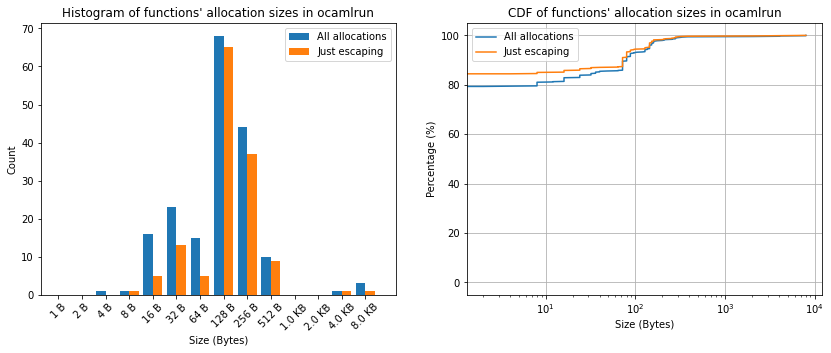

In [14]:
stack_allocation_sizes_histogram_and_cdf(ocamlrun_data, "ocamlrun", xlim=(0.3, 10000))

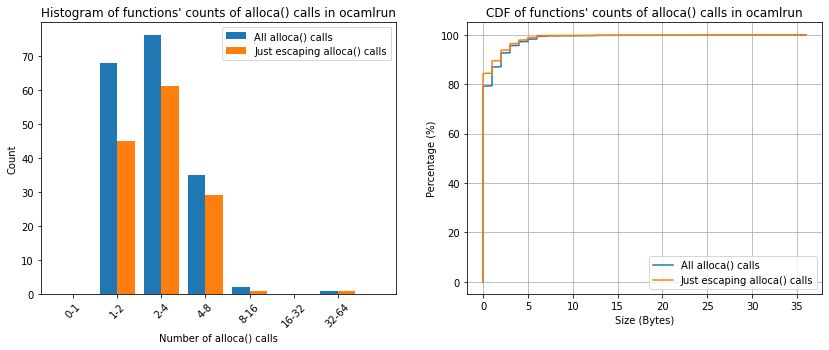

In [15]:
stack_allocation_counts_histogram_and_cdf(ocamlrun_data, "ocamlrun", xlim=(0.3, 80), log_cdf=False)

## Discussion

Looking at the data generated by EscapeAnalysisTool, I made two main observations:

- The allocations on average tend to be much larger than those of Grep. Presumably this is because the runtime needs to allocate large data structures to support the program.

- This time the majority of stack-allocated memory appears to be escaping. Perhaps this is because the runtime makes use of lots of closures, which the analysis tool correctly detects as possibly-escaping.

**TODO: Look at the source code for evidence of these assumptions!**

Let's take a look at what the functions with the most allocated memory are.

In [16]:
ocamlrun_data.nlargest(5, "TotalStaticallyAllocatedStackMemory")

,FunctionName,NumInstructions,NumAllocaInvocations,NumEscapingAllocaInvocations,NumDynamicallySizedAllocaInvocations,NumDynamicallySizedEscapingAllocaInvocations,TotalStaticallyAllocatedStackMemory,TotalStaticallyAllocatedEscapingStackMemory
805,ff_allocate,364,1,0,0,0,8000,0
567,caml_md5_channel,202,2,0,0,0,4184,0
506,caml_sys_getcwd,11,1,1,0,0,4096,4096
492,caml_hash,450,1,1,0,0,2048,2048
374,caml_array_concat,83,3,3,0,0,384,384


In [17]:
ocamlrun_data.nlargest(5, "TotalStaticallyAllocatedEscapingStackMemory")

,FunctionName,NumInstructions,NumAllocaInvocations,NumEscapingAllocaInvocations,NumDynamicallySizedAllocaInvocations,NumDynamicallySizedEscapingAllocaInvocations,TotalStaticallyAllocatedStackMemory,TotalStaticallyAllocatedEscapingStackMemory
506,caml_sys_getcwd,11,1,1,0,0,4096,4096
492,caml_hash,450,1,1,0,0,2048,2048
374,caml_array_concat,83,3,3,0,0,384,384
534,caml_reify_bytecode,200,12,12,0,0,320,320
100,caml_set_signal_action,30,2,2,0,0,304,304


This time the functions with the largest escaping stack allocations are not the same as those with the largest allocations overall.

The function with the largest overall static stack allocation is the C function `ff_allocate`, from the file `freelist.c` in the `runtime` directory. The function is long, occupying 179 lines of C code and translating to 597 lines of LLVM IR code. Importantly, while the size of the allocated memory is large at 8,000 bytes, the allocations have been condensed into a single `alloca` call in the LLVM IR code, despite coming from :

```
%2 = alloca [1000 x i64], align 16
```

# Key Points

**TODO: Add some kind of summary here, highlighting the things that were detected and what we need to consider when designing stack temporal safety solutions.**